In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 1000


In [2]:
## Date for the model
cases_date = '5_16_20'



#### Read coronavirus total cases data

In [3]:
dfcv = pd.read_csv('../files/covid_confirmed_usafacts.csv')

In [4]:
dates = dfcv.columns[4:]

changed_dates = {date: date.replace('/', '_') for date in dates}

dfcv = dfcv.rename(columns=changed_dates)

dfcv.countyFIPS = dfcv.countyFIPS.map(lambda x: '{:05d}'.format(x))

dfcv = dfcv.set_index('countyFIPS')

#### Prepare dataframe with cases and census data

In [5]:
df = pd.read_csv('../files/modeling_data/census_data.csv', index_col=0)

dft = pd.DataFrame(dfcv[cases_date])

df.index = df.index.map(lambda x: '{:05d}'.format(x))

df = df.join(dft)

df[cases_date] = 100_000 * df[cases_date] / df.TOT_POP

df.rename(columns={cases_date:'CPC'}, inplace = True)

df = df.reset_index()

df = df.rename(columns={'index':'FIPS'})

Drop Washington D.C.

In [6]:
# Drop the District of Columbia
df = df.loc[df.STNAME != 'District of Columbia']

len(df.STNAME.unique())

50

### Deal with missing values

In [7]:
# Columns with missing values
[col for col in df.columns if df[col].isnull().any()]

['Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Median_Household_Income_2018',
 'Rural_urban_continuum_code_2013',
 'Urban_influence_code_2013',
 'Metro_2013']

In [8]:
# Counties with missing values
counties_with_missing = dict()
for col in df.columns:
    if df[col].isnull().any():
        counties = df.loc[df[col].isnull()].CTYNAME.tolist()
        for county in counties:
            county_state = county + ', ' + df.loc[df.CTYNAME == county].STNAME.iloc[0]
            if county_state not in counties_with_missing:
                counties_with_missing[county_state] = [col]
            else:
                counties_with_missing[county_state].append(col)

In [9]:
counties_with_missing

{'Kalawao County, Hawaii': ['Civilian_labor_force_2018',
  'Employed_2018',
  'Unemployed_2018',
  'Median_Household_Income_2018',
  'Rural_urban_continuum_code_2013',
  'Urban_influence_code_2013',
  'Metro_2013']}

In [10]:
len(counties_with_missing)

1

There (were) only three counties with missing values, we manually googled and insert the land area values for the two counties with missing land areas and we can drop the county in Hawaii

In [11]:
df = df.loc[~(df.CTYNAME == 'Kalawao County')]

(0.07857035755102208, 1.0442235758093736e-05)

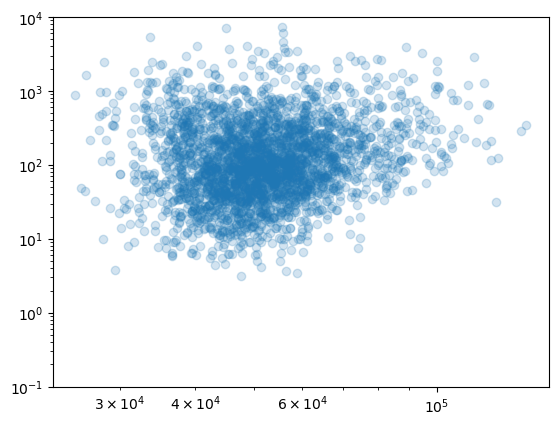

In [12]:
# side_data = df.loc[df.Metro_2013 == 1]
side_data = df

plt.style.use('default')
plt.scatter(side_data['Median_Household_Income_2018'], side_data.CPC, alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1, 10_000)
# plt.ylim(0.4, 0.55)

import scipy.stats as st
st.pearsonr(side_data['Median_Household_Income_2018'], side_data.CPC)

## Modeling

#### Categorical variables

In [13]:
# We should one hot encode the region
df.REGION.unique()

array([3, 4, 1, 2])

In [14]:
# These ordinal columns don't need to be changed but should be integers not floats
print(df['Rural_urban_continuum_code_2013'].sort_values().unique())

print(df['Urban_influence_code_2013'].sort_values().unique())

print(df.Metro_2013.sort_values().unique())

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[0. 1.]


We can first try dropping the state name, and then try one hot encoding the state name.

In [15]:
df['Rural_urban_continuum_code_2013'] = df['Rural_urban_continuum_code_2013'].astype(int)

df['Urban_influence_code_2013'] = df['Urban_influence_code_2013'].astype(int)

df['Metro_2013'] = df['Metro_2013'].astype(int)

df = df.reset_index(drop=True)

In [16]:
df

,FIPS,STATE,COUNTY,STNAME,CTYNAME,TOT_POP,TOT_MALE,TOT_FEMALE,WA,BA,IA,AA,NA,TOM,WAC,BAC,IAC,AAC,NAC,NH,NHWA,NHBA,NHIA,NHAA,NHNA,NHTOM,NHWAC,NHBAC,NHIAC,NHAAC,NHNAC,H,HWA,HBA,HIA,HAA,HNA,HTOM,HWAC,HBAC,HIAC,HAAC,HNAC,zero_four,five_nine,ten_fourteen,fifteen_nineteen,twenty_twentyfour,twentyfive_twentynine,thirty_thirtyfour,thirtyfive_thirtynine,forty_fortyfour,fortyfive_fortynine,fifty_fiftyfour,fiftyfive_fiftynine,sixty_sixtyfour,sixtyfive_sixtynine,seventy_seventyfour,seventyfive_seventynine,eighty_eightyfour,eightyfive_older,RNETMIG2018,RDOMESTICMIG2018,RINTERNATIONALMIG2018,RNATURALINC2018,RDEATH2018,RBIRTH2018,REGION,DIVISION,GQESTIMATES2018,NPOPCHG_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Median_Household_Income_2018,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18",LAND_AREA,DENSITY,med_age,CPC
0,01001,1,1,Alabama,Autauga County,55601,0.485513,0.514487,0.767252,0.196309,0.004802,0.012248,0.001115,0.018273,0.783799,0.206165,0.010270,0.017302,0.002104,0.970342,0.743080,0.193432,0.004370,0.012050,0.000773,0.016636,0.758296,0.202388,0.009029,0.016654,0.001493,0.029658,0.024172,0.002878,0.000432,0.000198,0.000342,0.001637,0.025503,0.003777,0.001241,0.000647,0.000611,0.060503,0.061564,0.069819,0.067535,0.057067,0.066635,0.062247,0.065251,0.065035,0.071330,0.068542,0.070628,0.058218,0.046564,0.041564,0.031276,0.020557,0.015665,0.630381,0.666403,-0.036022,2.215338,9.581787,11.797125,3,6,0.008183,0.002842,0.471143,0.964308,0.035692,59338.0,2,2,1,11.3,32.6,28.4,27.7,594.44,93.535092,37.8,197.838168
1,01003,1,3,Alabama,Baldwin County,218022,0.484616,0.515384,0.872852,0.089404,0.007724,0.011503,0.000670,0.017847,0.889598,0.096885,0.015939,0.015613,0.001624,0.953532,0.831113,0.087840,0.006701,0.011343,0.000509,0.016026,0.846300,0.094536,0.013870,0.015035,0.001211,0.046468,0.041739,0.001564,0.001023,0.000161,0.000161,0.001821,0.043298,0.002348,0.002069,0.000578,0.000413,0.054834,0.058719,0.064127,0.059315,0.050949,0.057201,0.055302,0.060343,0.059063,0.066328,0.065324,0.072213,0.071851,0.065438,0.057201,0.038826,0.023227,0.019741,24.846682,24.298662,0.548020,0.120750,10.347366,10.468116,3,6,0.010045,0.024782,0.436805,0.964046,0.035954,57588.0,3,2,1,9.7,27.6,31.3,31.3,1589.78,137.139730,42.6,116.502004
2,01005,1,5,Alabama,Barbour County,24881,0.527832,0.472168,0.490696,0.483984,0.006591,0.004542,0.001849,0.012339,0.500342,0.492906,0.011575,0.006069,0.002130,0.957236,0.456413,0.480326,0.003416,0.004542,0.001085,0.011455,0.465456,0.488606,0.007837,0.006029,0.001367,0.042764,0.034283,0.003657,0.003175,0.000000,0.000764,0.000884,0.034886,0.004300,0.003738,0.000040,0.000764,0.051606,0.058197,0.060649,0.058318,0.059162,0.072184,0.067119,0.061533,0.058277,0.065271,0.064427,0.067320,0.061734,0.061895,0.053736,0.036454,0.023150,0.018970,-8.593297,-9.072923,0.479626,-2.518036,12.949899,10.431863,3,6,0.113339,-0.011133,0.338170,0.949251,0.050749,34382.0,6,6,0,27.0,35.7,25.1,12.2,884.88,28.117937,39.7,317.511354
3,01007,1,7,Alabama,Bibb County,22400,0.532188,0.467813,0.768348,0.212946,0.004375,0.002366,0.001161,0.010804,0.778125,0.219018,0.008973,0.003795,0.001741,0.973750,0.745893,0.211205,0.003839,0.002321,0.000268,0.010223,0.755179,0.216920,0.008036,0.003750,0.000804,0.026250,0.022455,0.001741,0.000536,0.000045,0.000893,0.000580,0.022946,0.002098,0.000937,0.000045,0.000937,0.057366,0.052277,0.059196,0.056696,0.058170,0.077054,0.071473,0.067500,0.064286,0.071339,0.070580,0.068482,0.060848,0.052768,0.044286,0.032634,0.018839,0.016205,-6.584362,-7.029251,0.444889,-0.266934,11.389167,11.122233,3,6,0.096027,-0.006920,0.384152,0.960837,0.039163,46064.0,1,1,1,16.8,47.3,24.4,11.5,622.58,35.979312,39.8,223.214286
4,01009,1,9,Alabama,Blount County,57840,0

### Split the data

In [17]:
# Target is cases per capita
y = df.CPC
inverse_cols = ['TOT_MALE', 'Unemployed_2018', 'REGION']
# non_hispanic = [col for col in df.columns if col[:2] == 'NH']
object_cols = ['FIPS', 'COUNTY', 'CTYNAME', 'STATE']  # STNAME, DIVISION
dont_use = object_cols + inverse_cols


X = df.drop(dont_use + ['CPC'], axis=1)

In [18]:
from sklearn.model_selection import train_test_split

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, \
                                                      random_state=0)

### Select columns to one hot encode, then encode them


In [19]:
one_hot_columns = ['STNAME', 'DIVISION']

In [20]:
sorted_states = sorted(X_train.STNAME.unique().tolist())
assert len(sorted_states) == 50
sorted_states_dict = {i:sorted_states[i] for i in range(len(sorted_states))}

In [21]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit and apply one hot transformation
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(pd.DataFrame(X_train[one_hot_columns])))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(pd.DataFrame(X_valid[one_hot_columns])))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
X_train = X_train.drop(one_hot_columns, axis=1)
X_valid = X_valid.drop(one_hot_columns, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([X_train, OH_cols_train], axis=1)
X_valid = pd.concat([X_valid, OH_cols_valid], axis=1)

In [22]:
X_train.rename(columns=sorted_states_dict, inplace=True)
X_valid.rename(columns=sorted_states_dict, inplace=True)

In [23]:
# X_train.rename(columns={0:'REGION_1', 1:'REGION_2', 2:'REGION_3', 3:'REGION_4'}, inplace=True)
# X_valid.rename(columns={0:'REGION_1', 1:'REGION_2', 2:'REGION_3', 3:'REGION_4'}, inplace=True)

### Write functions for the results

In [26]:
features = {'51': 'New England Division of States', 
 'HBAC':'Percent Hispanic, Black, or African American alone or in combination',
 'NAC': 'Percent Native Hawaiian or Pacific Islander alone or in combination', 
 'thirty_thirtyfour':'Percent between the ages 30-34',
 'AA':'Percent Asian alone',
 'AAC': 'Percent Asian alone or in combination',
 '53': 'West North Central Division of States',
 'NHAA': 'Percent Not hispanic, Asian alone',
 'NHNA': 'Percent Not hispanic, Native Hawaiian or Pacific Islander alone',
 'HBA': 'Percent Hispanic, Black, or African American alone population',
 'BA': ' Percent Black or African American alone',
 'GQESTIMATES2018': 'Percent living in grouping quarters',
 'IAC': 'Percent american indian and Alaska Native alone or in combination',
 'NHBA': 'Percent Not Hispanic, Black or African American alone',
 'NHWAC': 'Not Hispanic, White alone or in combination',
 'TOT_POP': 'Total Population',
 'zero_four': 'Percent between the ages 0-4', 'DENSITY': 'Population density', 
 'HNA': 'Percent Hispanic, Native Hawaiian or Pacific Islander',
'Civilian_labor_force_2018': 'Percent of population in the labor force',
'WAC': 'Percent White alone or in combination',
'fifty_fiftyfour':'Percent between the ages 50-54',
'NHIAC': 'Percent Not Hispanic, American Indian and Alaska Native alone or in combination',
'BAC': 'Percent Black alone or in combination',
'TOT_FEMALE': 'Percent female',
'Median_Household_Income_2018': 'Median household income',
'H': 'Percent Hispanic',
'NH': 'Percent Not Hispanic',
'RINTERNATIONALMIG2018': 'Rate of international migration',
'RDEATH2018': 'Rate of death', 'HIA': 'Percent Hispanic, American Indian and Alaska Native alone',
'NA': 'Percent Native Hawaiian or Pacific Islander alone',
'NHWA': 'Percent Not Hispanic White alone',
'med_age': 'Median Age',
'seventy_seventyfour': 'Percent between the ages 70-74',
'thirtyfive_thirtynine': 'Percent between the ages 35-39',
'LAND_AREA': 'Land area'}

In [32]:
def most_important(X_train, importances):
    imp = list()
    for i in range(len(X_train.columns)):
        imp.append((X_train.columns[i],importances[i]))

    return sorted(imp, key=lambda x: x[1])

### Get results from random forest

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def score_dataset(X_train, X_valid, y_train, y_valid, n_estimators):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=1)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds), model.feature_importances_

In [31]:
performance, importances = score_dataset(X_train, X_valid, y_train, y_valid, n_estimators=100)

In [28]:
performance

181.65737616277906

In [29]:
len(X_train.columns)

135

In [30]:
rf_mi = most_important(X_train, importances)

In [31]:
rf_mi

[('New Hampshire', 4.332356838819882e-09),
 ('Alaska', 3.028379039077114e-07),
 ('West Virginia', 3.6046404878047543e-07),
 ('Hawaii', 5.128875850276759e-07),
 ('Vermont', 8.230513295882252e-07),
 ('Maine', 1.4625480641123573e-06),
 ('Oregon', 1.6145906267332979e-06),
 (58, 4.425519521343168e-06),
 ('California', 1.0755255806054835e-05),
 ('Nevada', 1.3135483091013546e-05),
 ('Wisconsin', 1.4779723451578255e-05),
 ('Rhode Island', 1.4780159068027026e-05),
 ('North Dakota', 2.058360340698793e-05),
 ('Montana', 2.9150230783102888e-05),
 ('South Carolina', 2.9365873752005882e-05),
 ('North Carolina', 4.3423734842203384e-05),
 ('Connecticut', 5.407481822957082e-05),
 ('Wyoming', 5.769119798793028e-05),
 ('Maryland', 7.999534671201248e-05),
 ('Pennsylvania', 9.94789865121888e-05),
 ('New Mexico', 0.00010273437735632022),
 ('Washington', 0.00010730524333690525),
 ('Illinois', 0.00011251578100567721),
 ('Kentucky', 0.00011403903962648792),
 ('Missouri', 0.00011895631169258368),
 ('Alabama', 0

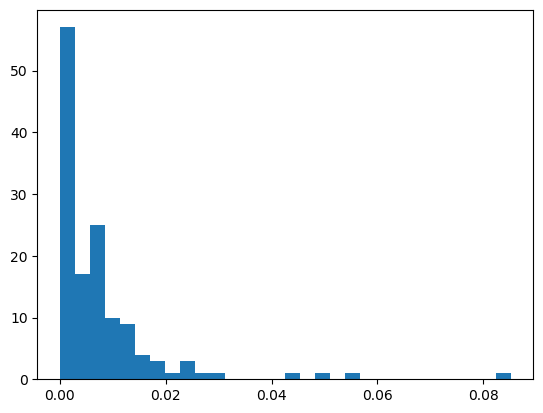

In [32]:
plt.hist(importances, bins=30)
plt.show()

In [33]:
df.columns

Index(['FIPS', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'TOT_POP', 'TOT_MALE',
       'TOT_FEMALE', 'WA', 'BA', 'IA', 'AA', 'NA', 'TOM', 'WAC', 'BAC', 'IAC',
       'AAC', 'NAC', 'NH', 'NHWA', 'NHBA', 'NHIA', 'NHAA', 'NHNA', 'NHTOM',
       'NHWAC', 'NHBAC', 'NHIAC', 'NHAAC', 'NHNAC', 'H', 'HWA', 'HBA', 'HIA',
       'HAA', 'HNA', 'HTOM', 'HWAC', 'HBAC', 'HIAC', 'HAAC', 'HNAC',
       'zero_four', 'five_nine', 'ten_fourteen', 'fifteen_nineteen',
       'twenty_twentyfour', 'twentyfive_twentynine', 'thirty_thirtyfour',
       'thirtyfive_thirtynine', 'forty_fortyfour', 'fortyfive_fortynine',
       'fifty_fiftyfour', 'fiftyfive_fiftynine', 'sixty_sixtyfour',
       'sixtyfive_sixtynine', 'seventy_seventyfour', 'seventyfive_seventynine',
       'eighty_eightyfour', 'eightyfive_older', 'RNETMIG2018',
       'RDOMESTICMIG2018', 'RINTERNATIONALMIG2018', 'RNATURALINC2018',
       'RDEATH2018', 'RBIRTH2018', 'REGION', 'DIVISION', 'GQESTIMATES2018',
       'NPOPCHG_2018', 'Civilian_labor_force_

In [253]:
import seaborn as sns

In [113]:
def plot_features(top, mi, model_name):
    plt.figure(figsize=(9,18))
    plt.style.use('default')
#     plt.style.use(np.random.choice(plt.style.available))
    # plt.style.use(np.random.choice(plt.style.available))
#     plt.title('{} top {} features from 2018 US Census county estimates with \n\
#     the greatest predictive power for COVID-19 cases per 100,000 people'.format(
#         model_name, top))
             #  fontsize=20)
    x = [str(p[0]) for p in mi][-top:]
    x = [features[k] if k in features else k for k in x]
    y = [p[1] for p in mi][-top:]
    sns.barplot(y[::-1], x[::-1], alpha=0.8)
    plt.grid(0.2)

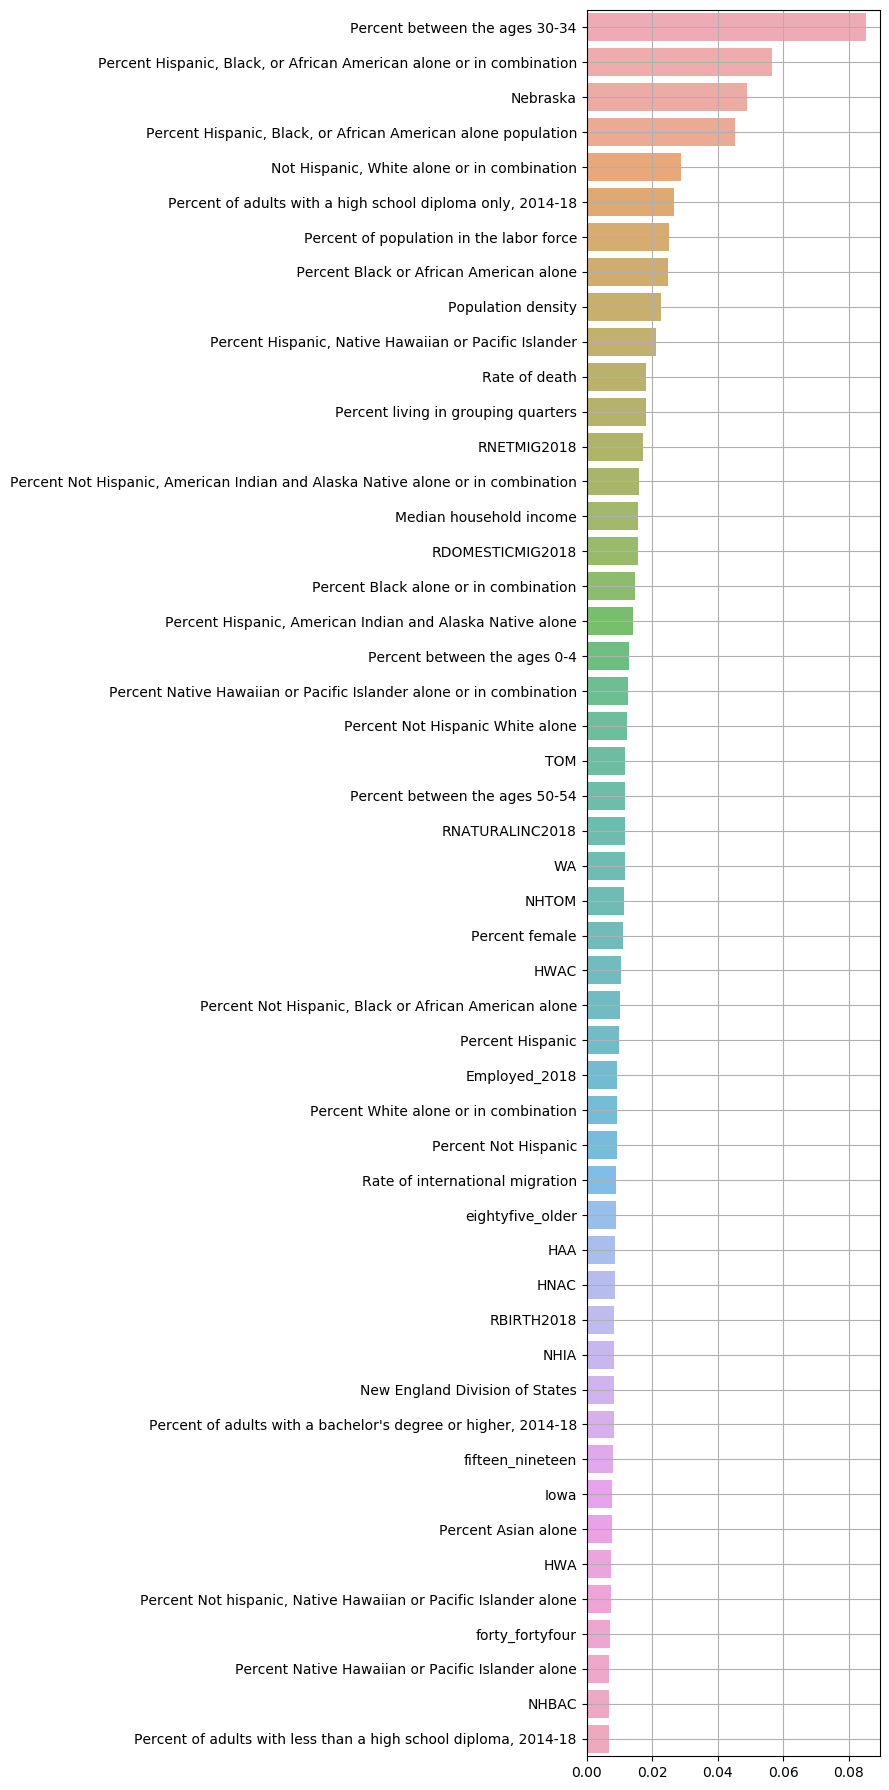

In [268]:
plot_features(top=50, mi=rf_mi, model_name='Random Forest')
plt.tight_layout()
plt.savefig('plots/rf_features.png', dpi=300)

Compare to if we just guessed the average cases per capita in the training data.

In [37]:
cpc_mean = np.zeros(X_valid.shape[0])
cpc_mean.fill(y_train.mean())

In [38]:
mean_absolute_error(cpc_mean, y_valid)

239.1999265607087

In [39]:
performance

181.65737616277906

In [40]:
1 - performance / mean_absolute_error(cpc_mean, y_valid)

0.2405625755212153

The model performs 24% better than if the prediction was simply an average of the cases per capita in the training data. 

In [41]:
performance / y_train.std()

0.3491012569307249

The mean absolute error was 35% of the standard deviation of the `y_train` values.

### Gradient boosting

Find the optimal number of estimators

In [140]:
from xgboost import XGBRegressor
boost_model = XGBRegressor(n_estimators=500)

boost_model.fit(X_train, y_train, early_stopping_rounds=5,
            eval_set=[(X_valid, y_valid)], verbose=True)

[02:29:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:528.166
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:517.24
[2]	validation_0-rmse:508.46
[3]	validation_0-rmse:500.127


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[4]	validation_0-rmse:491.451
[5]	validation_0-rmse:484.359
[6]	validation_0-rmse:477.618
[7]	validation_0-rmse:473.703
[8]	validation_0-rmse:468.707
[9]	validation_0-rmse:465.694
[10]	validation_0-rmse:464.38
[11]	validation_0-rmse:462.798
[12]	validation_0-rmse:457.583
[13]	validation_0-rmse:457.94
[14]	validation_0-rmse:457.758
[15]	validation_0-rmse:455.838
[16]	validation_0-rmse:453.98
[17]	validation_0-rmse:453.246
[18]	validation_0-rmse:449.034
[19]	validation_0-rmse:448.325
[20]	validation_0-rmse:447.178
[21]	validation_0-rmse:447.051
[22]	validation_0-rmse:447.482
[23]	validation_0-rmse:447.2
[24]	validation_0-rmse:446.95
[25]	validation_0-rmse:447.632
[26]	validation_0-rmse:446.972
[27]	validation_0-rmse:442.757
[28]	validation_0-rmse:442.94
[29]	validation_0-rmse:442.809
[30]	validation_0-rmse:439.378
[31]	validation_0-rmse:436.514
[32]	validation_0-rmse:432.762
[33]	validation_0-rmse:432.123
[34]	validation_0-rmse:430.979
[35]	validation_0-rmse:428.986
[36]	validation_0-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Ideal number of estimators was 157.

In [141]:
predictions = boost_model.predict(X_valid)
print("Mean Absolute Error: " + '{:,}'.format(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 172.94339554977645


In [142]:
1 - mean_absolute_error(predictions, y_valid) / mean_absolute_error(cpc_mean, y_valid)

0.27699227154284434

In [143]:
boost_maes = list()
for lr in np.arange(0.01, 0.3, 0.01):
    boost_model = XGBRegressor(n_estimators=170, learning_rate=lr)

    boost_model.fit(X_train, y_train)
    predictions = boost_model.predict(X_valid)

    mae = mean_absolute_error(predictions, y_valid)
    boost_maes.append(mae)
#     print("Mean Absolute Error: " + '{:,}'.format(mae))

/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:30:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


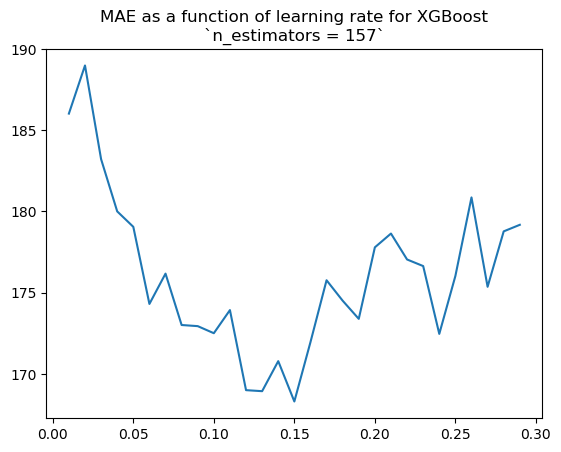

In [145]:
plt.plot(np.arange(0.01, 0.3, 0.01), boost_maes)
plt.title('MAE as a function of learning rate for XGBoost\n`n_estimators = 157`')
plt.savefig('plots/optimal_lr.png', dpi=300)
plt.show()

In [156]:
boost_model = XGBRegressor(n_estimators=200, learning_rate=0.15)

boost_model.fit(X_train, y_train)
predictions = boost_model.predict(X_valid)

performance = mean_absolute_error(predictions, y_valid)

/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:34:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [160]:
importances = boost_model.feature_importances_

XGBoost had with 157 estimators and 0.15 for the learning rate had a mean absolute error of 169, which is a 30% reduction in mean absolute error that is obtained from using the simple mean of the training data y values. In other words, the mean of the training data y values is the mean cases per 100,000 in the training counties. 

In [161]:
performance

168.45629629683054

In [162]:
1 - mean_absolute_error(predictions, y_valid) / mean_absolute_error(cpc_mean, y_valid)

0.29575105344325214

In [163]:
gb_mi = most_important(X_train, importances)

In [164]:
gb_mi

[('H', 0.0),
 ('Metro_2013', 0.0),
 ('Alabama', 0.0),
 ('Alaska', 0.0),
 ('Arizona', 0.0),
 ('Connecticut', 0.0),
 ('Hawaii', 0.0),
 ('Illinois', 0.0),
 ('Kansas', 0.0),
 ('Kentucky', 0.0),
 ('Maine', 0.0),
 ('Maryland', 0.0),
 ('Minnesota', 0.0),
 ('Montana', 0.0),
 ('Nevada', 0.0),
 ('New Hampshire', 0.0),
 ('North Dakota', 0.0),
 ('Oklahoma', 0.0),
 ('Oregon', 0.0),
 ('Pennsylvania', 0.0),
 ('South Dakota', 0.0),
 ('Vermont', 0.0),
 ('Virginia', 0.0),
 ('Washington', 0.0),
 ('West Virginia', 0.0),
 ('Wyoming', 0.0),
 (54, 0.0),
 (55, 0.0),
 (56, 0.0),
 ('Rhode Island', 0.0003972053),
 ('Mississippi', 0.00045668328),
 ('eighty_eightyfour', 0.00067213393),
 ('Wisconsin', 0.0006755674),
 (58, 0.00071443233),
 (50, 0.00071625697),
 ('HIAC', 0.0008429814),
 ('Michigan', 0.00091245683),
 ('med_age', 0.0009701974),
 ('California', 0.0010987014),
 (52, 0.0011299774),
 ('Missouri', 0.0012078845),
 ('fifteen_nineteen', 0.0014342372),
 ('NHBAC', 0.0017024467),
 ('NHAAC', 0.0017692457),
 ('Colo

In [112]:
plot_features(50, gb_mi, 'XGBoost')
plt.tight_layout()
plt.savefig('plots/xg_features.png', dpi=300)

NameError: name 'plot_features' is not defined

### Get the residuals for each county

In [37]:
fips_name = dict(zip(df.FIPS, df.CTYNAME+ ', ' + df.STNAME))

In [38]:
one_hot_columns = ['STNAME', 'DIVISION']

In [39]:
residuals_all = dict()
features_all = dict()
for row_idx in range(X.shape[0]):
    X_train = X.drop(row_idx)
    y_train = y.drop(row_idx)
    
    X_valid = X.iloc[row_idx:row_idx+1]
    y_valid = y.iloc[row_idx]
    
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

    # Fit and apply one hot transformation
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(pd.DataFrame(X_train[one_hot_columns])))
    OH_cols_valid = pd.DataFrame(OH_encoder.transform(pd.DataFrame(X_valid[one_hot_columns])))

    # One-hot encoding removed index; put it back
    OH_cols_train.index = X_train.index
    OH_cols_valid.index = X_valid.index

    # Remove categorical columns (will replace with one-hot encoding)
    X_train = X_train.drop(one_hot_columns, axis=1)
    X_valid = X_valid.drop(one_hot_columns, axis=1)

    # Add one-hot encoded columns to numerical features
    X_train = pd.concat([X_train, OH_cols_train], axis=1)
    X_valid = pd.concat([X_valid, OH_cols_valid], axis=1)
    
    X_train.rename(columns=sorted_states_dict, inplace=True)
    X_valid.rename(columns=sorted_states_dict, inplace=True)
    
    # County, State
    fip = df.FIPS.iloc[row_idx]
    
    # Model
    model = XGBRegressor(n_estimators=200, learning_rate=0.15)
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    
    # Store residual
    residual = (y_valid - pred)[0]
    residuals_all[fip] = residual
    
    # Store features
    features_all[fip] = most_important(X_train, model.feature_importances_)

Read saved XGBoost residuals from disk

In [40]:
dfr = pd.read_csv('public_data/xgb_county_residuals.csv').rename(columns={'Unnamed: 0': 'fips'})
dfr.fips = dfr.fips.apply(lambda x: str(x).zfill(5))

In [41]:
# dfr = pd.DataFrame([residuals_all, fips_name]).T.rename(columns={0:'residual', 1:'county_state'})

In [42]:
dfr

,fips,residual,county_state
0,01001,-9.839111,"Autauga County, Alabama"
1,01003,3.932831,"Baldwin County, Alabama"
2,01005,-190.207640,"Barbour County, Alabama"
3,01007,-135.137900,"Bibb County, Alabama"
4,01009,-109.677826,"Blount County, Alabama"
...,...,...,...
3135,56037,-195.980290,"Sweetwater County, Wyoming"
3136,56039,-24.728820,"Teton County, Wyoming"
3137,56041,-71.138490,"Uinta County, Wyoming"
3138,56043,-37.771027,"Washakie County, Wyoming"


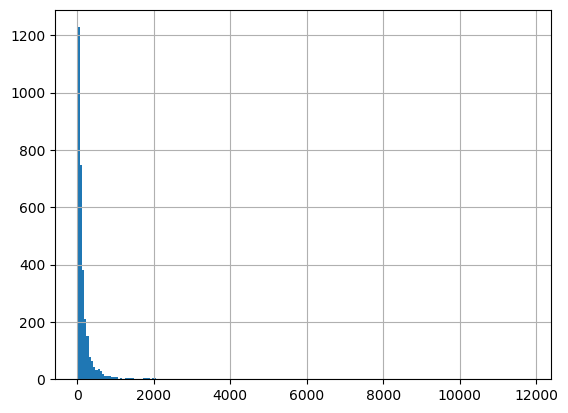

In [43]:
abs(dfr.residual).hist(bins=200)
# plt.xlim(-500, 500)

In [44]:
abs(dfr.residual).mean(), abs(dfr.residual).median(), abs(dfr.residual).std()

(175.6904272528629, 82.84667999999999, 392.7730917696885)

### Compare performance to using median or mean

In [45]:
residuals_xg = dfr.residual.to_numpy()

In [46]:
residuals_mean = np.zeros(X.shape[0])
residuals_median = np.zeros(X.shape[0])
for row_idx in range(X.shape[0]):
    X_train = X.drop(row_idx)
    y_train = y.drop(row_idx)
    
    X_valid = X.iloc[row_idx:row_idx+1]
    y_valid = y.iloc[row_idx]
    
    pred_mean = y_train.mean()
    residual_mean = y_valid - pred_mean
    residuals_mean[row_idx] = residual_mean
    
    pred_median = y_train.median()
    residual_median = y_valid - pred_median
    residuals_median[row_idx] = residual_median

In [47]:
abs_residuals_mean = abs(residuals_mean)
abs_residuals_median = abs(residuals_median)

In [48]:
def get_performance(array):
    return array.mean(), np.median(array), array.std()

In [49]:
get_performance(abs_residuals_mean)

(239.5349447521599, 176.03038094238673, 455.24288608483425)

In [50]:
get_performance(abs_residuals_median)

(196.42949274813628, 70.64294192612655, 496.4444532349214)

In [51]:
residuals_xg_median = (residuals_xg + residuals_median) / 2

In [52]:
get_performance(abs(residuals_xg_median))

(166.55451852545522, 67.412657828918, 421.0570348069226)

In [110]:
def plot_performance(array, model_name, top, color_order):
    sns.distplot(sorted(abs(array))[:-top], label=model_name,
                color=sns.color_palette()[color_order])
    if color_order == 0:
        mae_text = ' M.A.E.'
    else:
        mae_text = ' M.A.E.'
    plt.axvline(x=abs(array).mean(), 
                color=sns.color_palette()[color_order], label=model_name + mae_text, 
                linestyle='--', alpha=0.6)

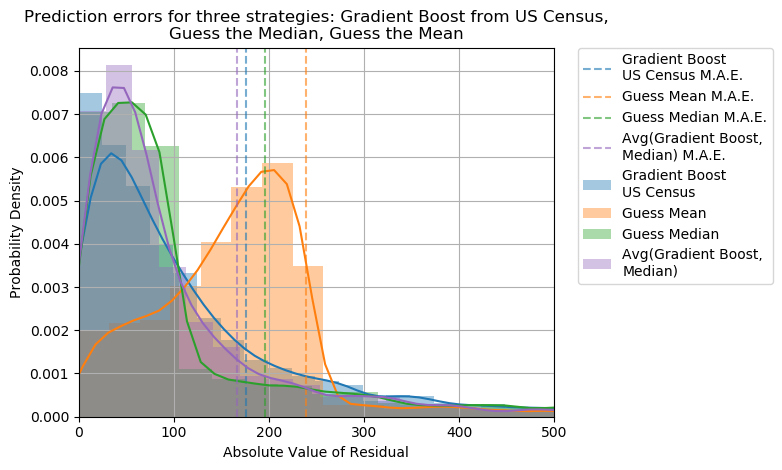

In [111]:
top = 50
plt.figure(figsize=(8, 4.8))
plt.title('Prediction errors for three strategies: Gradient Boost from US Census,\n\
Guess the Median, Guess the Mean')

plt.style.use('default')

plot_performance(residuals_xg, 'Gradient Boost\nUS Census', top, 0)
plot_performance(residuals_mean, 'Guess Mean', top, 1)
plot_performance(residuals_median, 'Guess Median', top, 2)

plot_performance(residuals_xg_median, 'Avg(Gradient Boost,\nMedian)', top, 4)

plt.xlim(0, 500)
# plt.xticks(np.arange(0, 550, 50))
plt.legend()
plt.grid(0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Probability Density')
plt.xlabel('Absolute Value of Residual')
plt.tight_layout()
plt.savefig('plots/prediction_errors.png', dpi=300)
plt.show()

The counties that have a lot fewer cases than the model predicted. 

In [55]:
dfr.sort_values(by='residual')[:20]

,fips,residual,county_state
2268,42053,-3950.66260,"Forest County, Pennsylvania"
2857,51081,-2412.20530,"Greensville County, Virginia"
85,02185,-2378.68460,"North Slope Borough, Alaska"
538,13309,-1994.87700,"Wheeler County, Georgia"
2932,51683,-1881.26210,"Manassas city, Virginia"
1426,28055,-1878.01070,"Issaquena County, Mississippi"
1634,30077,-1850.92770,"Powell County, Montana"
513,13259,-1838.78040,"Stewart County, Georgia"
2647,48253,-1570.67800,"Jones County, Texas"
797,19021,-1511.31790,"Buena Vista County, Iowa"


### Try a simple decision tree.

In [60]:
from sklearn.tree import DecisionTreeRegressor

In [63]:
for max_leaf_nodes in np.arange(5, 105, 5):
    dt_model = DecisionTreeRegressor(random_state = 0, max_leaf_nodes=max_leaf_nodes)
    dt_model.fit(X_train, y_train)
    print(max_leaf_nodes, mean_absolute_error(dt_model.predict(X_valid), y_valid), sep='\t')

5	226.35836525886137
10	214.41563186047838
15	216.1741492683636
20	222.90570111724202
25	219.96550220862875
30	216.80350428926192
35	213.50540738392283
40	212.6512698925887
45	216.36714192876272
50	216.46474796663412
55	217.6518091284348
60	216.78065483934196
65	221.19779540003506
70	221.379866028697
75	221.5314059442881
80	221.45246473691068
85	221.62138725745092
90	221.05576160099736
95	225.87817503991434
100	227.2645788705097


The performance of the decision tree isn't great. 

#### Message to the reader:
* `dfr`  refers to the dataframe with the XGBoost alone residuals.
* `dr` refers to the dataframe with the Avg(XGBoost, median) residuals.

In [56]:
dr = pd.DataFrame(fips_name.items(), residuals_xg_median).reset_index().rename(
    columns={'index': 'residual', 0:'fips', 1:'county_state'})

In [58]:
dr.sort_values(by='residual')[:20]

,residual,fips,county_state
2268,-1973.753792,42053,"Forest County, Pennsylvania"
85,-1235.866795,02185,"North Slope Borough, Alaska"
2857,-1037.591899,51081,"Greensville County, Virginia"
538,-999.541114,13309,"Wheeler County, Georgia"
1426,-985.529845,28055,"Issaquena County, Mississippi"
1634,-971.988345,30077,"Powell County, Montana"
1055,-679.308495,21129,"Lee County, Kentucky"
1512,-673.823232,29063,"DeKalb County, Missouri"
513,-667.460988,13259,"Stewart County, Georgia"
818,-665.441342,19063,"Emmet County, Iowa"


In [80]:
dfresid = pd.concat([dfr.rename(columns={'residual': 'xgb_residual'}), 
           pd.DataFrame(dr.rename(columns={'residual':
                                           'xgb_median_residual'}).xgb_median_residual)], axis=1)

In [82]:
# dfresid.to_csv('public_data/both_residuals.csv')

### Get performance of XGB and Avg(XGB, median)

In [102]:
def plot_r2(dataframe_test, dataframe_gen, model_name):
    x = -(dataframe_test.residual - dataframe_gen.CPC)
    y = dataframe_gen.CPC
    plt.grid(alpha=0.4)
    plt.scatter(x, df.CPC, alpha=0.1, edgecolors=None)
    exp = '{} predictions versus True COVID-19\nCases per 100,000. '.format(model_name)
    r2 = '$r$ = {:.3f}, $p < 0.001$'.format(st.pearsonr(x, y)[0]) # **2
    plt.title(exp + r2)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(0.1, 10_000)
    plt.xlim(0.1, 10_000)
    plt.xticks([0.1, 1, 10, 100, 1000, 10_000], 
               ['0.1', '1', '10', '100', '1,000', '10,000'])
    plt.yticks([0.1, 1, 10, 100, 1000, 10_000], 
               ['0.1', '1', '10', '100', '1,000', '10,000'])
    plt.xlabel('{} predicted Cases per 100,000'.format(model_name))
    plt.ylabel('True Cases per 100,000')
    
    if model_name == 'Avg(XGBoost, Median)':
        plt.axvline(x=df.CPC.median(), linestyle='--', alpha=0.8, label='Overall Median')
        plt.legend()
        
    plt.tight_layout()

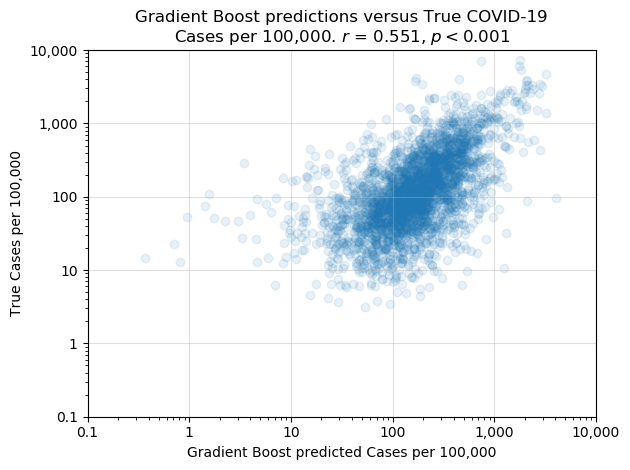

In [103]:
plot_r2(dfr, df, 'Gradient Boost')

plt.savefig('plots/xgb_performance.png', dpi=300)

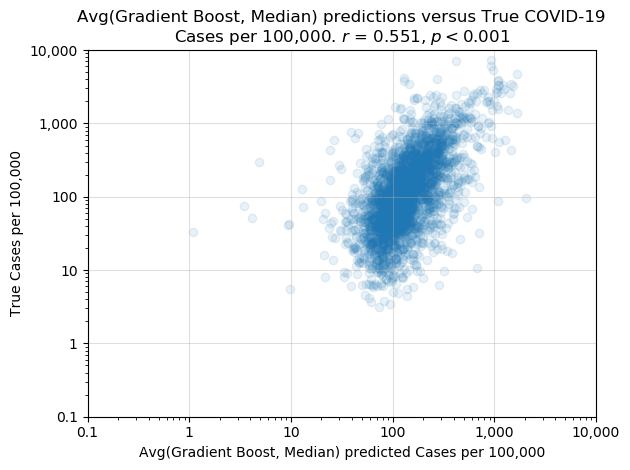

In [104]:
plot_r2(dr, df, 'Avg(Gradient Boost, Median)')
plt.savefig('plots/xgb_median_performance.png', dpi=300)